##### TEST COMPARATIVI TRA TUTTI I MODELLI CON TABELLA DELLE PRECISIONI SUL TEST SET

- Pulizia dati

In [1]:
from fastai.tabular.all import *
from warnings import simplefilter
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from pytorch_widedeep.preprocessing import TabPreprocessor
from pytorch_widedeep.models import *
from pytorch_widedeep import Trainer
from pytorch_widedeep.metrics import Accuracy
from torch.optim import SGD, lr_scheduler
from pytorch_widedeep.initializers import XavierNormal
from pytorch_widedeep.utils import LabelEncoder
from pytorch_widedeep.self_supervised_training import ContrastiveDenoisingTrainer
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import catboost as cb
from xgboost import XGBClassifier
set_seed(42)
simplefilter(action="ignore", category=FutureWarning)

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [2]:
df = pd.read_csv('clinvar.22.dbnsfp.vcf', sep='\t')
df = df.apply(lambda x: x.str.split(';') if x.dtype == "object" else x)
df = df.map(lambda x: x.remove('') if type(x) is list and '' in x else x)

l = []

for col in df.columns:
    if df[col].apply(lambda x: len(x) if type(x) is list else list()).equals(df['aapos'].apply(lambda x: len(x) if type(x) is list else list())):
        l.append(col)

l.append('TSL')
df = df.explode(l)
df = df.map(lambda x: x[0] if type(x) is list and len(x) == 1 else x)
df.replace(to_replace='.', value=np.nan, inplace=True)
df.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
####
#df.dropna(axis='columns', thresh=int(len(df.index)*0.8), inplace=True)
####
df = df.apply(pd.to_numeric, errors='ignore')


l1 = []

for col in df.columns:
    if df[col].map(lambda x: True if type(x) is list else False).any():
        l1.append(col)

for col in l1:
    v = df[col].explode().value_counts()
    toRemove = v[v < int(len(df[col].explode()) * 0.10)].index

/tmp/ipykernel_72101/1594310657.py:1: DtypeWarning: Columns (98,99,101,102,131,132,133,134,135,136,153,154,155,169,170,171,172,646,650,651,675,676,677,678,679,681,682,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,705,706,717,718,719,720,721,722,723,724,725,730) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('clinvar.22.dbnsfp.vcf', sep='\t')


In [3]:
df.apply(pd.to_numeric, errors='ignore')
#df.replace(to_replace=np.nan, value=0, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'not_provided'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'protective'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_other,_risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'drug_response'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'association'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Affects'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'other'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'drug_response,_risk_factor'].index, inplace=True)
df.replace(to_replace='Conflicting_interpretations_of_pathogenicity', value='Uncertain_significance', inplace=True)
df.replace(to_replace='Benign/Likely_benign', value='Likely_benign', inplace=True)
df.replace(to_replace='Likely_benign,_other', value='Likely_benign', inplace=True)
df.replace(to_replace='Likely_benign,_drug_response,_other', value='Likely_benign', inplace=True)
df.replace(to_replace='Benign/Likely_benign,_other', value='Likely_benign', inplace=True)
df.replace(to_replace='Pathogenic/Likely_pathogenic', value='Likely_pathogenic', inplace=True)
df.replace(to_replace='Benign/Likely_benign,_risk_factor', value='Likely_pathogenic', inplace=True)
df.reset_index(drop=True, inplace=True)

In [4]:
df1 = pd.read_csv('clinvar.hg19.chr21.dbnsfp.tsv', sep='\t')
df1 = df1.apply(lambda x: x.str.split(';') if x.dtype == "object" else x)
df1 = df1.map(lambda x: x.remove('') if type(x) is list and '' in x else x)

l = []

for col in df1.columns:
    if df1[col].apply(lambda x: len(x) if type(x) is list else list()).equals(df1['aapos'].apply(lambda x: len(x) if type(x) is list else list())):
        l.append(col)

l.append('TSL')
df1 = df1.explode(l)
df1 = df1.map(lambda x: x[0] if type(x) is list and len(x) == 1 else x)
df1.replace(to_replace='.', value=np.nan, inplace=True)
df1.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
#####
#df1.dropna(axis='columns', thresh=int(len(df1.index)*0.8), inplace=True)
#####
df1 = df1.apply(pd.to_numeric, errors='ignore')


l1 = []

for col in df1.columns:
    if df1[col].map(lambda x: True if type(x) is list else False).any():
        l1.append(col)

for col in l1:
    v = df1[col].explode().value_counts()
    toRemove = v[v < int(len(df1[col].explode()) * 0.10)].index
    df1[col] = df1[col].map(lambda x: [i for i in x if i not in toRemove] if type(x) is list else x)

/tmp/ipykernel_72101/800033988.py:1: DtypeWarning: Columns (98,99,101,102,131,132,133,134,135,136,153,154,155,169,170,171,172,646,650,651,675,676,677,678,679,681,682,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,705,706,717,718,719,720,721,722,723,724,725,730) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('clinvar.hg19.chr21.dbnsfp.tsv', sep='\t')


In [5]:
df1.apply(pd.to_numeric, errors='ignore')
#df1.replace(to_replace=np.nan, value=0, inplace=True)
df1.drop(axis='index', labels=df1[df1.clinvar_clnsig == 'not_provided'].index, inplace=True)
df1.drop(axis='index', labels=df1[df1.clinvar_clnsig == 'protective'].index, inplace=True)
df1.drop(axis='index', labels=df1[df1.clinvar_clnsig == 'risk_factor'].index, inplace=True)
df1.drop(axis='index', labels=df1[df1.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_risk_factor'].index, inplace=True)
df1.drop(axis='index', labels=df1[df1.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_other,_risk_factor'].index, inplace=True)
df1.replace(to_replace='Conflicting_interpretations_of_pathogenicity', value='Uncertain_significance', inplace=True)
df1.replace(to_replace='Benign/Likely_benign', value='Benign', inplace=True)
df1.replace(to_replace='Pathogenic/Likely_pathogenic', value='Pathogenic', inplace=True)
df1.reset_index(drop=True, inplace=True)

In [6]:
df2 = pd.read_csv('dbsnp.common.20.intervar.hg19_multianno.txt', sep='\t')
df2 = df2.drop(df2[df2['CLNSIG'] == '.'].index)
df2 = df2.map(lambda x: x.split(';') if type(x) is str and len(x.split(';')) > 1 else x)
df2 = df2.map(lambda x: x.remove('') if type(x) is list and '' in x else x)
l = []

for col in df2.columns:
    if df2[col].apply(lambda x: True if type(x) is list and len(x) > 2 else False).any():
        l.append(col)

for col in l:
    if col == 'Interpro_domain':
        df2 = df2.explode(col)
    else:
        df2.drop(col, axis=1, inplace=True)

df2 = df2.map(lambda x: x[0] if type(x) is list else x)
df2.replace(to_replace='.', value=np.nan, inplace=True)
df2.dropna(axis='rows', how='any', inplace=True, subset=['CLNSIG'])
#df2.dropna(axis='columns', thresh=int(len(df2.index)*0.8), inplace=True)
df2 = df2.apply(pd.to_numeric, errors='ignore')

df2.apply(pd.to_numeric, errors='ignore')
#df2.replace(to_replace=np.nan, value=0, inplace=True)
df2.drop(axis='index', labels=df2[df2.CLNSIG == 'not_provided'].index, inplace=True)
df2.drop(axis='index', labels=df2[df2.CLNSIG == 'protective'].index, inplace=True)
df2.drop(axis='index', labels=df2[df2.CLNSIG == 'risk_factor'].index, inplace=True)
df2.drop(axis='index', labels=df2[df2.CLNSIG == 'Conflicting_interpretations_of_pathogenicity,_risk_factor'].index, inplace=True)
df2.drop(axis='index', labels=df2[df2.CLNSIG == 'Conflicting_interpretations_of_pathogenicity,_other,_risk_factor'].index, inplace=True)
df2.drop(axis='index', labels=df2[df2.CLNSIG == 'association'].index, inplace=True)
df2.drop(axis='index', labels=df2[df2.CLNSIG == 'drug_response'].index, inplace=True)
df2.replace(to_replace='Conflicting_interpretations_of_pathogenicity', value='Uncertain_significance', inplace=True)
df2.replace(to_replace='Benign/Likely_benign', value='Benign', inplace=True)
df2.replace(to_replace='Pathogenic/Likely_pathogenic', value='Pathogenic', inplace=True)
df2.reset_index(drop=True, inplace=True)
df2 = df2.rename({"CLNSIG": "clinvar_clnsig", "Ref": "ref", "Alt": "alt", "Chr": "#chr"}, axis="columns")

In [7]:
a = np.intersect1d(df.columns, df1.columns)
b = np.intersect1d(df2.columns, a)
df_concat = pd.concat([df[b], df1[b], df2[b]])
df_concat.dropna(axis='columns', thresh=int(len(df2.index)*0.8), inplace=True)
df_concat.replace(to_replace=np.nan, value=0, inplace=True)
df_concat.replace(to_replace='-', value=0, inplace=True)

In [8]:
l2 = []

for col in df_concat.columns:
    if df_concat[col].map(lambda x: True if type(x) is list else False).any():
        l2.append(col)

df_concat.drop(axis='columns', labels=l2, inplace=True)

In [9]:
from sklearn.model_selection import train_test_split

df_concat, df_test = train_test_split(df_concat, test_size=0.2)

In [10]:
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df_concat))
df_data = df_concat.drop(columns=['clinvar_clnsig'], inplace=False)
num_cols = df_data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_data.select_dtypes(include=[object]).columns.tolist()
df_concat = df_concat.sample(frac=1).reset_index(drop=True)

In [11]:
to = TabularPandas(df_concat, procs=[Categorify, FillMissing],
                   cat_names = cat_cols,
                   cont_names = num_cols,
                   y_names='clinvar_clnsig',
                    y_block=CategoryBlock(),
                   splits=splits)

In [12]:
dls = to.dataloaders(bs=1024)

In [13]:
precision_dict = {}

- Tabular learner standard con focal loss (fastai)

In [14]:
learn = tabular_learner(dls, metrics=accuracy, loss_func=FocalLossFlat(gamma=5))

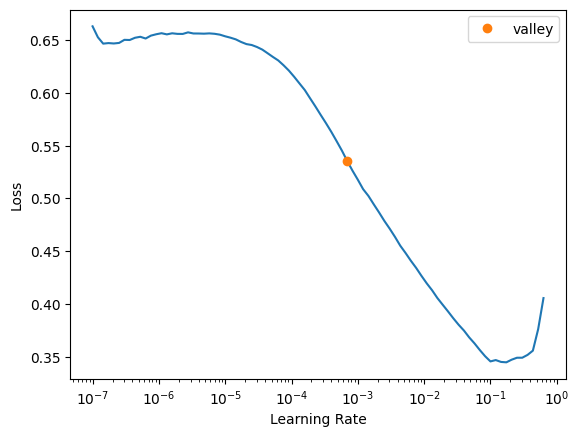

In [15]:
lr = learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.216778,0.155132,0.798579,00:00
1,0.168818,0.117413,0.822842,00:00
2,0.136464,0.093251,0.836066,00:00
3,0.109599,0.073731,0.856940,00:00
4,0.086516,0.061041,0.869945,00:00
5,0.067531,0.054339,0.875956,00:00
6,0.052702,0.049632,0.887213,00:00
7,0.041485,0.043878,0.890383,00:00
8,0.033075,0.042904,0.899563,00:00
9,0.027223,0.043619,0.893771,00:00


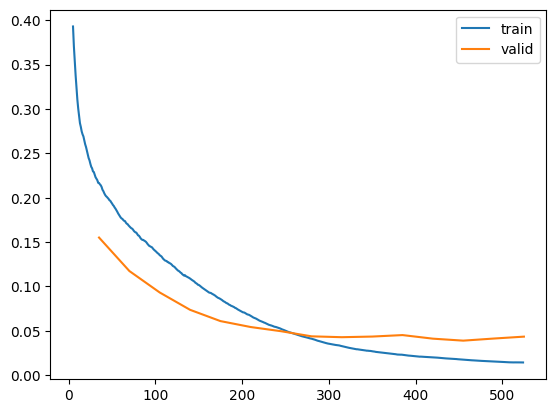

In [16]:
learn.fit(15, lr)
learn.recorder.plot_loss()

In [17]:
test_dl = dls.test_dl(df_test)
loss, standard_learn = learn.validate(dl=test_dl)

In [18]:
precision_dict['standard'] = standard_learn

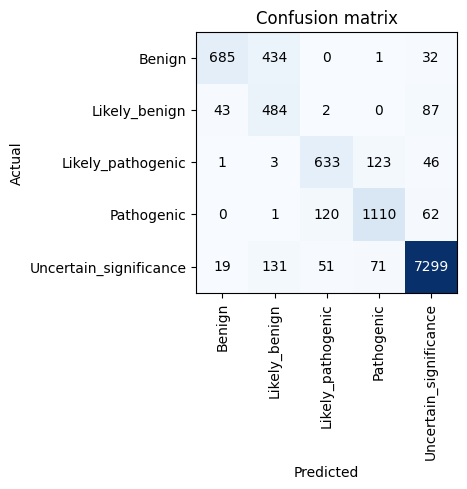

In [19]:
interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)
interp.plot_confusion_matrix()

- Tabular learner standard con con loss function customizzata (Focal loss + penalizzazione per classi sbilanciate)

In [20]:
classes = {0: 1, 1: 1, 2: 2, 3: 2, 4: 3}

class GroupLoss(nn.Module):
    def __init__(self, gamma = 2.0):
        super(GroupLoss, self).__init__()
        self.gamma = gamma

    def forward(self, inp, targ):
        sm_acts = torch.softmax(inp, dim=1)
        losses = []
        for i in range(len(targ)):
            target_class = classes[targ[i].item()]
            pred_class = sm_acts[i].argmax().item()
            if target_class != classes[pred_class]:
                losses.append(torch.pow(1 - sm_acts[i][targ[i].item()], self.gamma) * torch.log(sm_acts[i][targ[i].item()]) * 3)
            else:
                losses.append(torch.pow(1 - sm_acts[i][targ[i].item()], self.gamma) * torch.log(sm_acts[i][targ[i].item()]))
      
        return -torch.stack(losses).mean()

In [21]:
learn = tabular_learner(dls, metrics=accuracy, loss_func=GroupLoss(gamma=6))

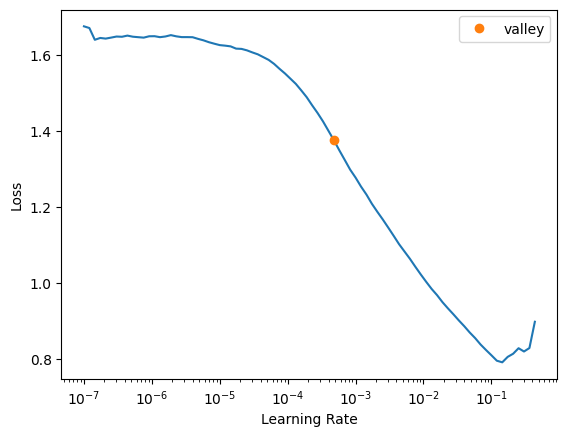

In [22]:
torch.cuda.empty_cache()
lr = learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.485316,0.299270,0.783934,00:22
1,0.364860,0.252228,0.795956,00:22
2,0.292421,0.202062,0.824590,00:22
3,0.236863,0.161282,0.842732,00:22
4,0.192009,0.136213,0.857377,00:22
5,0.153556,0.108134,0.867213,00:22
6,0.121107,0.099003,0.869727,00:22
7,0.094246,0.099693,0.845574,00:22
8,0.073124,0.079497,0.876066,00:22
9,0.057937,0.079199,0.880874,00:22


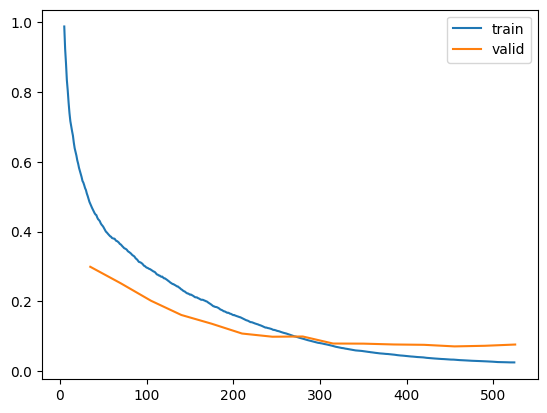

In [23]:
learn.fit(15, lr)
learn.recorder.plot_loss()

In [24]:
test_dl = dls.test_dl(df_test)
loss, custom_learner = learn.validate(dl=test_dl)

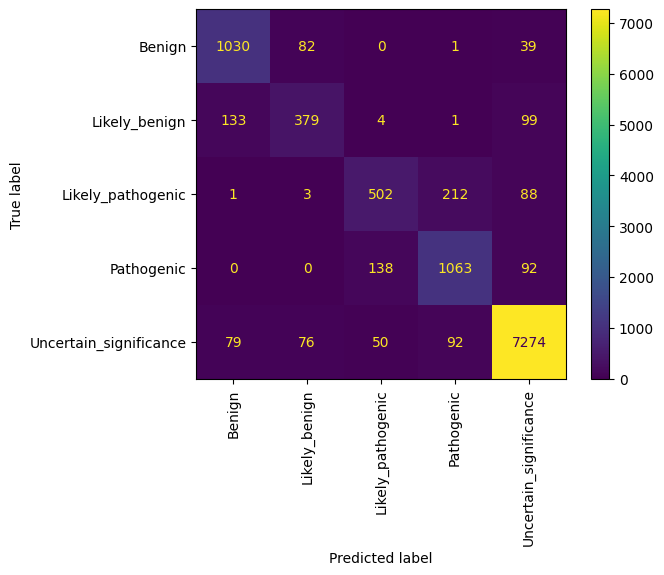

In [25]:
preds, targets = learn.get_preds(dl=test_dl)
pred_classes = np.argmax(preds, axis=1)

# Flattening delle etichette di classe
true_classes = targets.squeeze().numpy()

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(true_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dls.vocab)
disp.plot(xticks_rotation='vertical')

In [26]:
precision_dict['custom'] = custom_learner

- Gradient Boosting

In [27]:
df_data = df_concat.drop(columns=['clinvar_clnsig'], inplace=False)
num_cols = df_data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_data.select_dtypes(include=[object]).columns.tolist()
df_concat = df_concat.sample(frac=1).reset_index(drop=True)

to2 = TabularPandas(df_concat, procs=[Categorify, FillMissing],
                   cat_names = cat_cols,
                   cont_names = num_cols,
                   y_names='clinvar_clnsig',
                    y_block=CategoryBlock())

X_train, y_train = to2.train.xs, to2.train.ys.values.ravel()

In [28]:
to_test = TabularPandas(df_test, procs=[Categorify, FillMissing], cat_names = cat_cols, cont_names = num_cols, y_names='clinvar_clnsig', y_block=CategoryBlock())
X_test = to_test.train.xs
y_test = to_test.train.ys.values.ravel()

In [29]:
parameters = {
    "loss":['log_loss'],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.01, 1, 20, endpoint=False),
    "min_samples_leaf": np.linspace(0.01, 1, 20, endpoint=False),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ['friedman_mse', 'squared_error'],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[200, 400, 600, 800]
    }

clf = RandomizedSearchCV(GradientBoostingClassifier(), parameters, cv=3, n_iter=50, n_jobs=-1)

clf.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error'],
                                        'learning_rate': [0.01, 0.025, 0.05,
                                                          0.075, 0.1, 0.15,
                                                          0.2],
                                        'loss': ['log_loss'],
                                        'max_depth': [3, 5, 8],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': array([0.01  , 0.0595, 0.109 , 0.1585, 0.208 , 0.2575, 0.307 , 0.3565,
       0.406 , 0.4555, 0.505 , 0.5545, 0.604 , 0.6535, 0.703 , 0.7525,
       0.802 , 0.8515, 0.901 , 0.9505]),
                                        'min_samples_split': array([0.01  , 0.0595, 0.109 , 0.1585, 0.208 , 0.2575, 0.307 , 0.3565,
       0.406 , 0.4555, 0.505 , 0.5545, 0.604 , 0.6535, 0.703 , 0.7525,
       0.802 , 0.8515, 0.901 , 0.9505]),
                                        'n_estimators': [200, 400, 600, 800],
                                        'subsample': [0.5, 0.618, 0.8, 0.85,
                                                      0.9, 0.95, 1.0]})

In [30]:
p = clf.predict(X_test)

0.9713236579821647

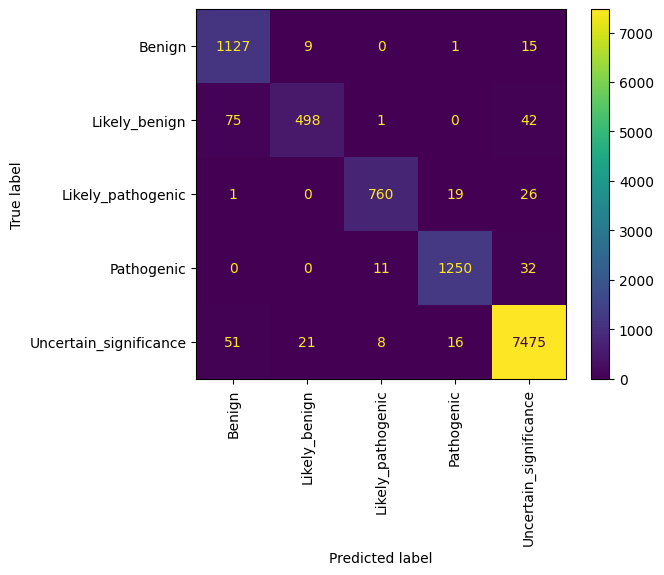

In [31]:
cm = confusion_matrix(y_test, p)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dls.vocab)
disp.plot(xticks_rotation='vertical')
accuracy_score(y_test, p)

In [32]:
gradient_boosting_precision = accuracy_score(y_test, p)

In [33]:
precision_dict['gradient_boosting'] = gradient_boosting_precision

- Random Forest

In [34]:
rfc = RandomForestClassifier(random_state=42, max_features='log2', max_depth=200, criterion='gini', min_samples_leaf=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=200, max_features='log2', random_state=42)

In [35]:
pred=rfc.predict(X_test)

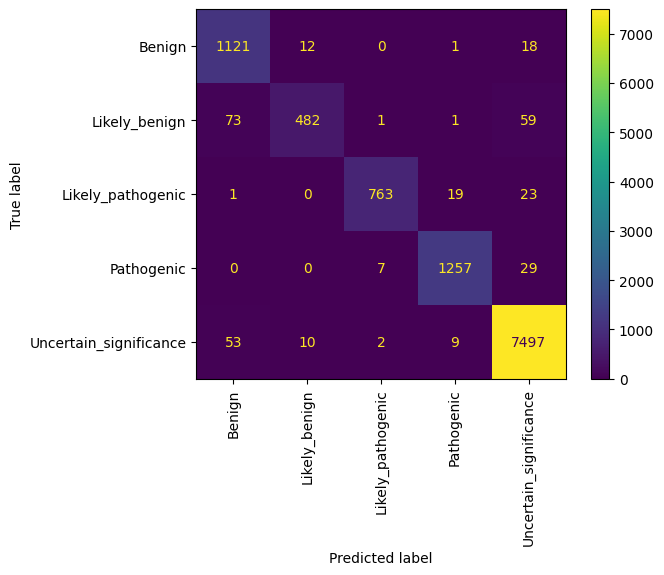

In [36]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dls.vocab)
disp.plot(xticks_rotation='vertical')

In [37]:
rf_accuracy = accuracy_score(y_test, pred)

In [38]:
precision_dict['random_forest'] = rf_accuracy

- Voting Classifier

In [39]:
class FastAITabularClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, dls, layers, metrics):
        self.dls = dls
        self.layers = layers
        self.metrics = metrics
        self.learn = None

    def fit(self, X, y):
        # Convert X, y into a FastAI DataLoaders
        self.learn = tabular_learner(self.dls, metrics=self.metrics, loss_func=FocalLossFlat(gamma=5))
        lr = self.learn.lr_find()
        self.learn.fit(15, lr) # You can adjust the training method and epochs
        return self

    def predict_proba(self, X):
        dl = self.dls.test_dl(X, with_labels=False)
        preds, _ = self.learn.get_preds(dl=dl)
        return preds.numpy()
        #return preds.argmax(dim=1).numpy()

In [40]:
fastai_model = FastAITabularClassifier(dls, layers=[200,100], metrics=accuracy)

In [41]:
voting_clf = VotingClassifier(estimators=[
    ('rf', rfc),
    ('gbm', clf),
    ('fastai', fastai_model)
], voting='soft')

epoch,train_loss,valid_loss,accuracy,time
0,0.233786,0.171387,0.808306,00:00
1,0.181355,0.125078,0.827650,00:00
2,0.145130,0.097710,0.850055,00:00
3,0.114478,0.077006,0.861967,00:00
4,0.089377,0.068546,0.867213,00:00
5,0.068819,0.056337,0.880219,00:00
6,0.052730,0.051257,0.889508,00:00
7,0.040887,0.050495,0.887213,00:00
8,0.032582,0.045316,0.897377,00:00
9,0.027201,0.046110,0.900984,00:00


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=200,
                                                     max_features='log2',
                                                     random_state=42)),
                             ('gbm',
                              RandomizedSearchCV(cv=3,
                                                 estimator=GradientBoostingClassifier(),
                                                 n_iter=50, n_jobs=-1,
                                                 param_distributions={'criterion': ['friedman_mse',
                                                                                    'squared_error'],
                                                                      'learning_rate': [0.01,
                                                                                        0.025,
                                                                                        0.05,
                                                                                        0.075,
                                                                                        0.1,
                                                                                        0.15,
                                                                                        0.2],
                                                                      'loss': ['log_loss'],
                                                                      'max_depth'...
                                                                      'min_samples_split': array([0.01  , 0.0595, 0.109 , 0.1585, 0.208 , 0.2575, 0.307 , 0.3565,
       0.406 , 0.4555, 0.505 , 0.5545, 0.604 , 0.6535, 0.703 , 0.7525,
       0.802 , 0.8515, 0.901 , 0.9505]),
                                                                      'n_estimators': [200,
                                                                                       400,
                                                                                       600,
                                                                                       800],
                                                                      'subsample': [0.5,
                                                                                    0.618,
                                                                                    0.8,
                                                                                    0.85,
                                                                                    0.9,
                                                                                    0.95,
                                                                                    1.0]})),
                             ('fastai',
                              FastAITabularClassifier(dls=<fastai.tabular.data.TabularDataLoaders object at 0x7fd066328130>,
                                                      layers=[200, 100],
                                                      metrics=<function accuracy at 0x7fd09c40c790>))],
                 voting='soft')

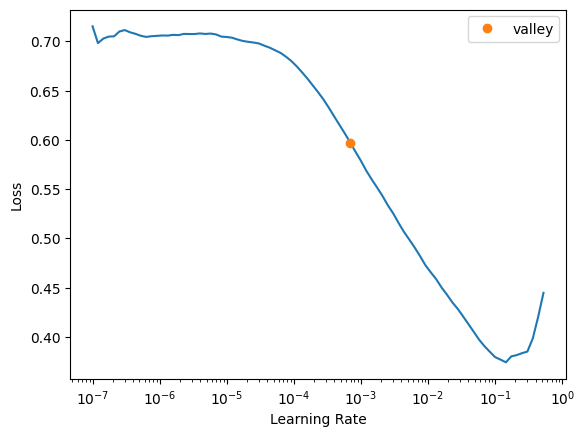

In [42]:
voting_clf.fit(X_train, y_train)

0.9492918342367547

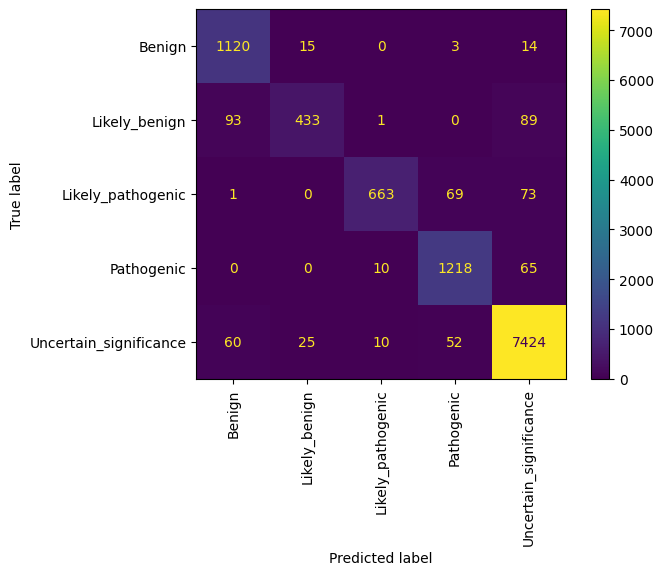

In [43]:
predictions =  voting_clf.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dls.vocab)
disp.plot(xticks_rotation='vertical')
accuracy_score(y_test, predictions)

In [44]:
precision_dict['voting'] = accuracy_score(y_test, predictions)

- Xgboost

In [45]:
xgb_class = XGBClassifier(
        n_jobs=multiprocessing.cpu_count() // 2, tree_method="hist",
        max_depth=8, n_estimators=400, random_state=42
    )

In [46]:
xgb_class.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=8,
              num_parallel_tree=None, objective='multi:softprob', ...)

0.9753453400944221

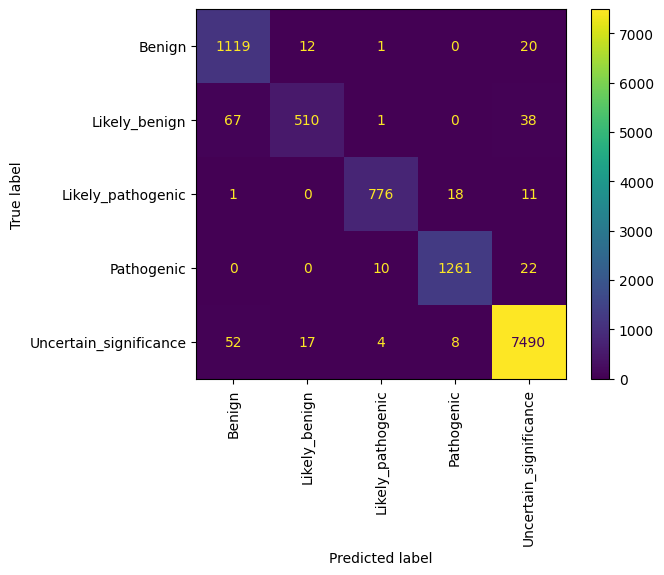

In [47]:
predictions =  xgb_class.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dls.vocab)
disp.plot(xticks_rotation='vertical')
accuracy_score(y_test, predictions)

In [48]:
precision_dict['xgboost'] = accuracy_score(y_test, predictions)

- Voting Classifier con Xgboost e Random Forest

In [49]:
voting_clf = VotingClassifier(estimators=[
    ('rf', rfc),
    ('xgb', xgb_class),   
], voting='soft')

In [50]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=200,
                                                     max_features='log2',
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=No...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=8,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=400, n_jobs=8,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...))],
                 voting='soft')

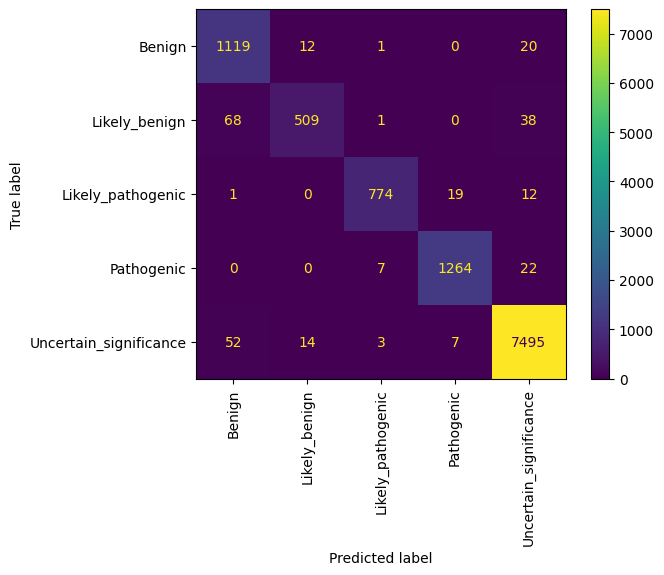

In [51]:
predictions =  voting_clf.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dls.vocab)
disp.plot(xticks_rotation='vertical')
voting_score = accuracy_score(y_test, predictions)

In [52]:
precision_dict['voting_xgb_rf'] = voting_score

- MultiModal

In [53]:
encoder = LabelEncoder(["clinvar_clnsig"])
df_concat = encoder.fit_transform(df_concat)
df_concat["clinvar_clnsig"] = df_concat["clinvar_clnsig"] - 1

In [54]:
target = 'clinvar_clnsig'
target = df_concat[target].values

In [55]:
embed_cols = [(col, 40) for col in cat_cols]

In [56]:
tab_preprocessor = TabPreprocessor(
    cat_embed_cols=embed_cols, 
    continuous_cols=num_cols 
)

In [57]:
X_tab = tab_preprocessor.fit_transform(df_concat)

/home/andrea/.local/lib/python3.10/site-packages/pytorch_widedeep/preprocessing/tab_preprocessor.py:360: UserWarning: Continuous columns will not be normalised
  warnings.warn("Continuous columns will not be normalised")


- TabMlp

In [58]:
tab_mlp = TabMlp(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=num_cols,
)
model = WideDeep(deeptabular=tab_mlp, pred_dim=5)
deep_opt = SGD(model.deeptabular.parameters(), lr=0.001)
deep_sch = lr_scheduler.StepLR(deep_opt, step_size=3)
trainer = Trainer(model, objective="multiclass", metrics=[Accuracy], device='cuda')
trainer.fit(
    X_tab=X_tab,
    target=target,
    n_epochs=20,
    batch_size=256,
    val_split=0.2,
)

valid: 100%|██████████| 36/36 [00:00<00:00, 65.37it/s, loss=0.379, metrics={'acc': 0.8796}]


In [59]:
X_tab_te = tab_preprocessor.transform(df_test)
preds = trainer.predict(X_tab=X_tab_te)

predict: 100%|██████████| 45/45 [00:00<00:00, 84.51it/s] 


In [60]:
d = encoder.create_inverse_encoding_dict()
e = d['clinvar_clnsig']

In [61]:
preds = [e[i+1] for i in preds]

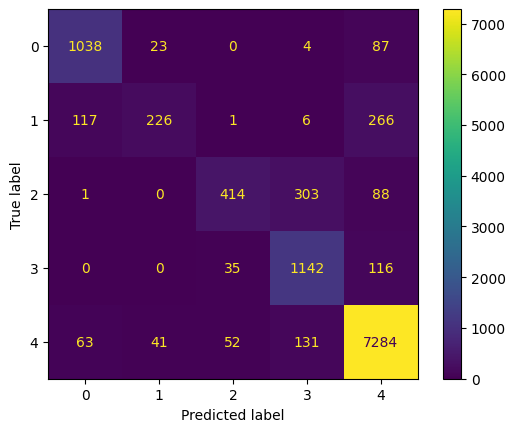

In [62]:
cm = confusion_matrix(df_test['clinvar_clnsig'], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [63]:
precision_dict['wide_deep'] = accuracy_score(df_test['clinvar_clnsig'], preds)

- ContextAttentionMLP

In [64]:
tab_mlp = ContextAttentionMLP(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=num_cols,
)
model = WideDeep(deeptabular=tab_mlp, pred_dim=5)
deep_opt = SGD(model.deeptabular.parameters(), lr=0.001)
deep_sch = lr_scheduler.StepLR(deep_opt, step_size=3)
trainer = Trainer(model, objective="multiclass", metrics=[Accuracy], device='cuda')
trainer.fit(
    X_tab=X_tab,
    target=target,
    n_epochs=20,
    batch_size=256,
    val_split=0.2,
)

valid: 100%|██████████| 36/36 [00:00<00:00, 70.74it/s, loss=0.929, metrics={'acc': 0.7219}]


predict: 100%|██████████| 45/45 [00:00<00:00, 85.63it/s]


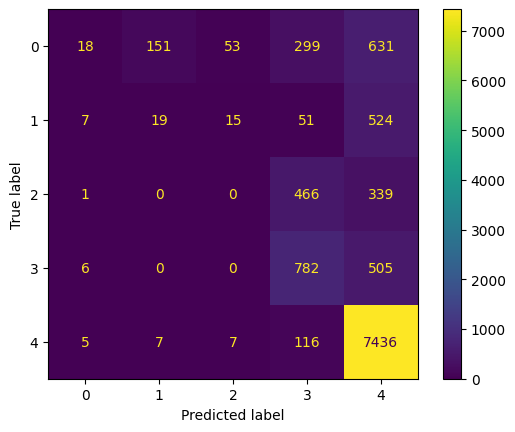

In [65]:
X_tab_te = tab_preprocessor.transform(df_test)
preds = trainer.predict(X_tab=X_tab_te)
preds = [e[i+1] for i in preds]
cm = confusion_matrix(df_test['clinvar_clnsig'], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [66]:
precision_dict['context_attention'] = accuracy_score(df_test['clinvar_clnsig'], preds)

- SelfAttentionMLP

In [67]:
tab_mlp = SelfAttentionMLP(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=num_cols,
)
model = WideDeep(deeptabular=tab_mlp, pred_dim=5)
deep_opt = SGD(model.deeptabular.parameters(), lr=0.001)
deep_sch = lr_scheduler.StepLR(deep_opt, step_size=3)
trainer = Trainer(model, objective="multiclass", metrics=[Accuracy], device='cuda')
trainer.fit(
    X_tab=X_tab,
    target=target,
    n_epochs=20,
    batch_size=256,
    val_split=0.2,
)

valid: 100%|██████████| 36/36 [00:00<00:00, 53.15it/s, loss=0.458, metrics={'acc': 0.8389}]


predict: 100%|██████████| 45/45 [00:00<00:00, 59.57it/s]


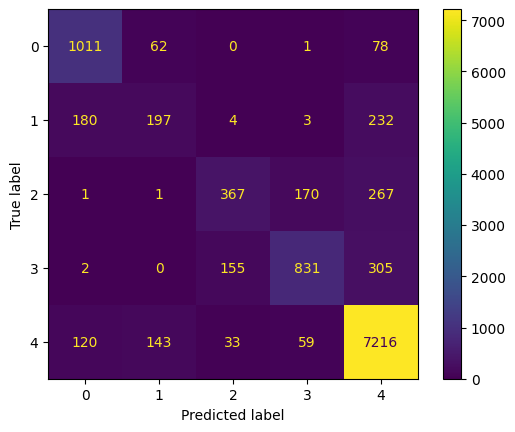

In [68]:
X_tab_te = tab_preprocessor.transform(df_test)
preds = trainer.predict(X_tab=X_tab_te)
preds = [e[i+1] for i in preds]
cm = confusion_matrix(df_test['clinvar_clnsig'], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [69]:
precision_dict['self_attention'] = accuracy_score(df_test['clinvar_clnsig'], preds)

- TabResnet

In [70]:
tab_mlp = TabResnet(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=num_cols,
)
model = WideDeep(deeptabular=tab_mlp, pred_dim=5)
deep_opt = SGD(model.deeptabular.parameters(), lr=0.001)
deep_sch = lr_scheduler.StepLR(deep_opt, step_size=3)
trainer = Trainer(model, objective="multiclass", metrics=[Accuracy], device='cuda')
trainer.fit(
    X_tab=X_tab,
    target=target,
    n_epochs=20,
    batch_size=256,
    val_split=0.2,
)

valid: 100%|██████████| 36/36 [00:00<00:00, 52.88it/s, loss=0.332, metrics={'acc': 0.8976}]


predict: 100%|██████████| 45/45 [00:00<00:00, 71.14it/s]


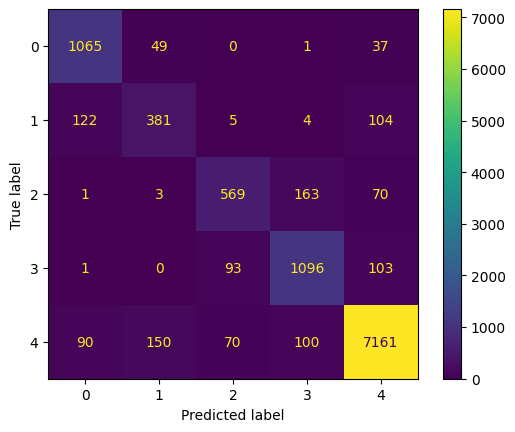

In [71]:
X_tab_te = tab_preprocessor.transform(df_test)
preds = trainer.predict(X_tab=X_tab_te)
preds = [e[i+1] for i in preds]
cm = confusion_matrix(df_test['clinvar_clnsig'], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [72]:
precision_dict['resnet'] = accuracy_score(df_test['clinvar_clnsig'], preds)

- Tabnet

In [73]:
tab_mlp = TabNet(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=num_cols,
)
model = WideDeep(deeptabular=tab_mlp, pred_dim=5)
deep_opt = SGD(model.deeptabular.parameters(), lr=0.001)
deep_sch = lr_scheduler.StepLR(deep_opt, step_size=3)
trainer = Trainer(model, objective="multiclass", metrics=[Accuracy], device='cuda')
trainer.fit(
    X_tab=X_tab,
    target=target,
    n_epochs=20,
    batch_size=256,
    val_split=0.2,
)

  0%|          | 0/143 [00:00<?, ?it/s]

valid: 100%|██████████| 36/36 [00:00<00:00, 37.74it/s, loss=0.585, metrics={'acc': 0.8179}]


predict: 100%|██████████| 45/45 [00:00<00:00, 45.37it/s]


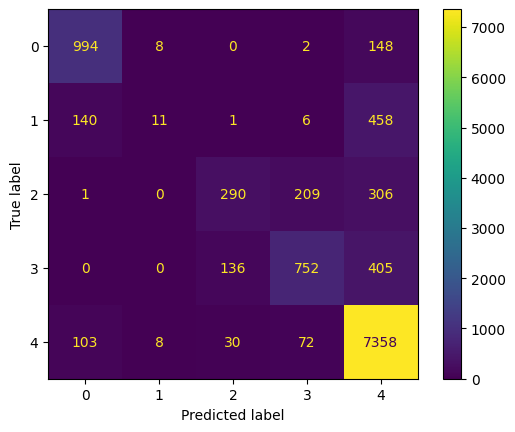

In [74]:
X_tab_te = tab_preprocessor.transform(df_test)
preds = trainer.predict(X_tab=X_tab_te)
preds = [e[i+1] for i in preds]
cm = confusion_matrix(df_test['clinvar_clnsig'], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [75]:
precision_dict['tabnet'] = accuracy_score(df_test['clinvar_clnsig'], preds)

- Tabtransformer

In [76]:
tab_mlp = TabTransformer(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=num_cols,
)
model = WideDeep(deeptabular=tab_mlp, pred_dim=5)
deep_opt = SGD(model.deeptabular.parameters(), lr=0.001)
deep_sch = lr_scheduler.StepLR(deep_opt, step_size=3)
trainer = Trainer(model, objective="multiclass", metrics=[Accuracy], device='cuda')
trainer.fit(
    X_tab=X_tab,
    target=target,
    n_epochs=20,
    batch_size=256,
    val_split=0.2,
)

valid: 100%|██████████| 36/36 [00:00<00:00, 62.59it/s, loss=0.401, metrics={'acc': 0.8597}]


predict: 100%|██████████| 45/45 [00:00<00:00, 73.63it/s]


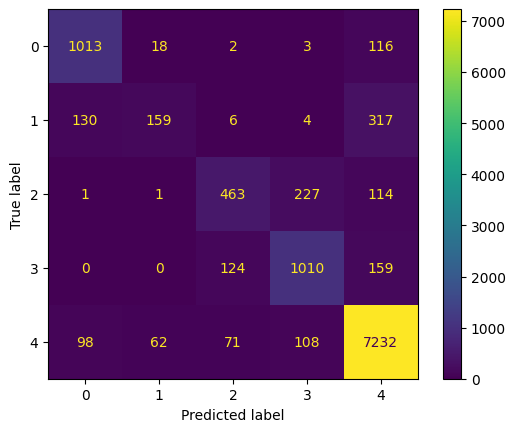

In [77]:
X_tab_te = tab_preprocessor.transform(df_test)
preds = trainer.predict(X_tab=X_tab_te)
preds = [e[i+1] for i in preds]
cm = confusion_matrix(df_test['clinvar_clnsig'], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [78]:
precision_dict['transformer'] = accuracy_score(df_test['clinvar_clnsig'], preds)

- FtTransformer

In [79]:
tab_mlp = FTTransformer(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=num_cols,
)
model = WideDeep(deeptabular=tab_mlp, pred_dim=5)
deep_opt = SGD(model.deeptabular.parameters(), lr=0.001)
deep_sch = lr_scheduler.StepLR(deep_opt, step_size=3)
trainer = Trainer(model, objective="multiclass", metrics=[Accuracy], device='cuda')
trainer.fit(
    X_tab=X_tab,
    target=target,
    n_epochs=20,
    batch_size=256,
    val_split=0.2,
)

valid: 100%|██████████| 36/36 [00:00<00:00, 42.88it/s, loss=0.343, metrics={'acc': 0.9126}]


predict: 100%|██████████| 45/45 [00:00<00:00, 53.45it/s]


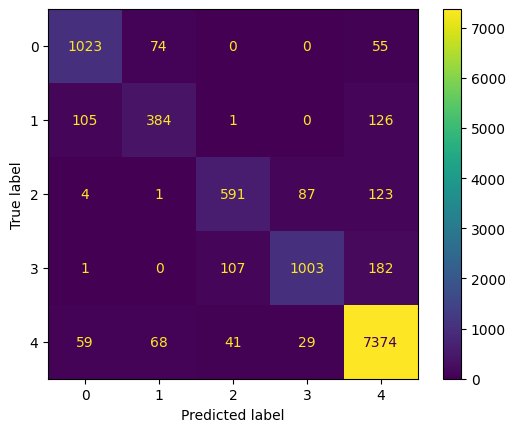

In [80]:
X_tab_te = tab_preprocessor.transform(df_test)
preds = trainer.predict(X_tab=X_tab_te)
preds = [e[i+1] for i in preds]
cm = confusion_matrix(df_test['clinvar_clnsig'], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [81]:
precision_dict['ft_transformer'] = accuracy_score(df_test['clinvar_clnsig'], preds)

- SAINT

In [82]:
tab_mlp = SAINT(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=num_cols,
)
model = WideDeep(deeptabular=tab_mlp, pred_dim=5)
deep_opt = SGD(model.deeptabular.parameters(), lr=0.001)
deep_sch = lr_scheduler.StepLR(deep_opt, step_size=3)
trainer = Trainer(model, objective="multiclass", metrics=[Accuracy], device='cuda')
trainer.fit(
    X_tab=X_tab,
    target=target,
    n_epochs=20,
    batch_size=256,
    val_split=0.2,
)

valid: 100%|██████████| 36/36 [00:01<00:00, 32.63it/s, loss=1.11, metrics={'acc': 0.6664}]


predict: 100%|██████████| 45/45 [00:01<00:00, 37.68it/s]


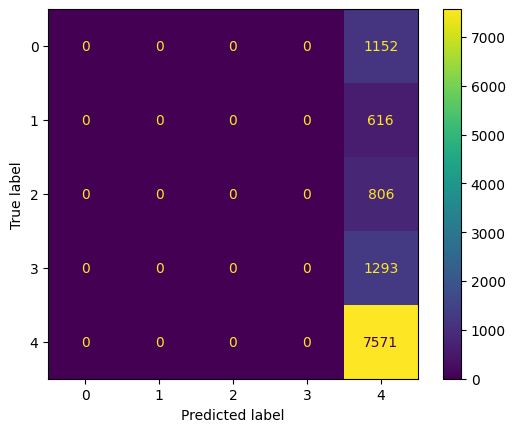

In [83]:
X_tab_te = tab_preprocessor.transform(df_test)
preds = trainer.predict(X_tab=X_tab_te)
preds = [e[i+1] for i in preds]
cm = confusion_matrix(df_test['clinvar_clnsig'], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [84]:
precision_dict['saint'] = accuracy_score(df_test['clinvar_clnsig'], preds)

- TabFastformer

In [85]:
tab_mlp = TabFastFormer(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=num_cols,
)
model = WideDeep(deeptabular=tab_mlp, pred_dim=5)
deep_opt = SGD(model.deeptabular.parameters(), lr=0.001)
deep_sch = lr_scheduler.StepLR(deep_opt, step_size=3)
trainer = Trainer(model, objective="multiclass", metrics=[Accuracy], device='cuda')
trainer.fit(
    X_tab=X_tab,
    target=target,
    n_epochs=20,
    batch_size=256,
    val_split=0.2,
)

valid: 100%|██████████| 36/36 [00:00<00:00, 57.17it/s, loss=0.382, metrics={'acc': 0.8677}]


predict: 100%|██████████| 45/45 [00:00<00:00, 65.29it/s]


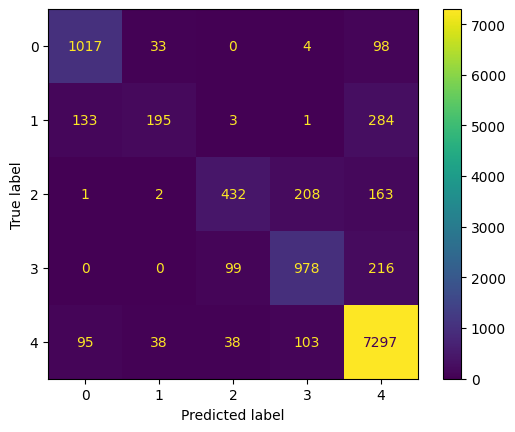

In [86]:
X_tab_te = tab_preprocessor.transform(df_test)
preds = trainer.predict(X_tab=X_tab_te)
preds = [e[i+1] for i in preds]
cm = confusion_matrix(df_test['clinvar_clnsig'], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [87]:
precision_dict['fastformer'] = accuracy_score(df_test['clinvar_clnsig'], preds)

- TabPerceiver

In [88]:
tab_mlp = TabPerceiver(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=num_cols,
)
model = WideDeep(deeptabular=tab_mlp, pred_dim=5)
deep_opt = SGD(model.deeptabular.parameters(), lr=0.001)
deep_sch = lr_scheduler.StepLR(deep_opt, step_size=3)
trainer = Trainer(model, objective="multiclass", metrics=[Accuracy], device='cuda')
trainer.fit(
    X_tab=X_tab,
    target=target,
    n_epochs=20,
    batch_size=256,
    val_split=0.2,
)

valid: 100%|██████████| 36/36 [00:01<00:00, 34.76it/s, loss=0.455, metrics={'acc': 0.8469}]


predict: 100%|██████████| 45/45 [00:01<00:00, 41.48it/s]


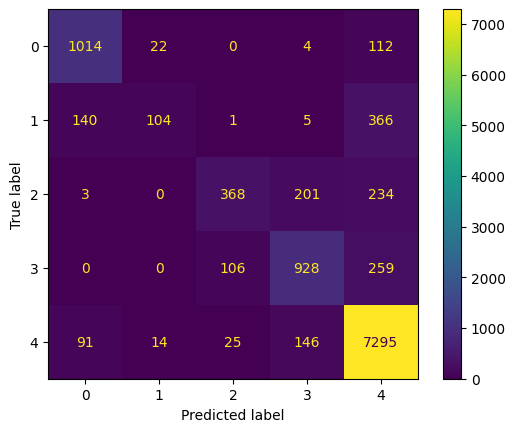

In [89]:
X_tab_te = tab_preprocessor.transform(df_test)
preds = trainer.predict(X_tab=X_tab_te)
preds = [e[i+1] for i in preds]
cm = confusion_matrix(df_test['clinvar_clnsig'], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [90]:
precision_dict['perceiver'] = accuracy_score(df_test['clinvar_clnsig'], preds)

- CatBoost

In [91]:
df_concat.to_csv('df_concat.csv', index=False)

In [92]:
y = df_concat['clinvar_clnsig']
X = df_concat.drop(columns=['clinvar_clnsig'], inplace=False)
for col in cat_cols:
    X[col] = X[col].map(lambda x: str(x))

In [93]:
train_pool = Pool(X, y, cat_features=cat_cols)

In [94]:
grid = {'learning_rate': [0.03, 0.1],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'num_trees': [100, 500, 1000, 2000],
        'max_depth': [4, 6, 8, 10],}

In [95]:
#model = CatBoostClassifier(iterations=100, loss_function='MultiClass', eval_metric='Accuracy', border_count=254, task_type="GPU", devices='0')

In [96]:
#model.save_model('catboost_model', format='cbm', pool=train_pool)

In [97]:
model = CatBoostClassifier()

In [98]:
model.load_model('catboost_model', format='cbm')

In [99]:
y_test = df_test['clinvar_clnsig']
X_Test = df_test.drop(columns=['clinvar_clnsig'], inplace=False)
for col in cat_cols:
    X_Test[col] = X_Test[col].map(lambda x: str(x))

In [100]:
d = encoder.create_inverse_encoding_dict()
e = d['clinvar_clnsig']

In [101]:
preds = model.predict(X_Test).flatten()
#preds = [e[i+1] for i in preds]

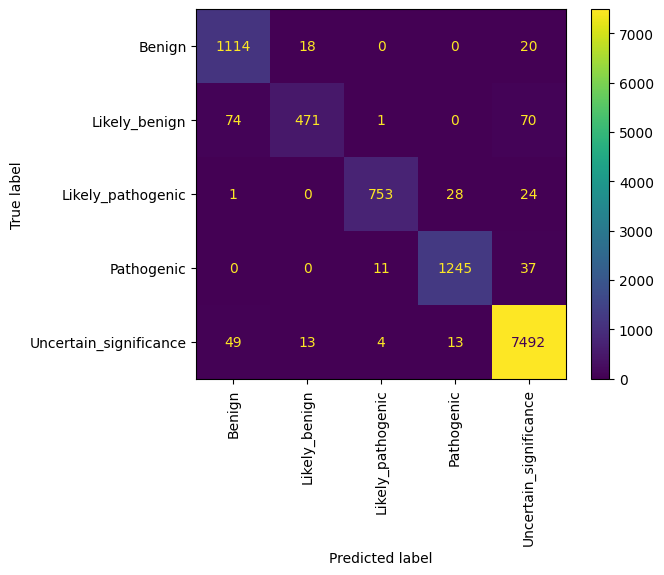

In [102]:
preds = model.predict(X_Test)
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dls.vocab)
disp.plot(xticks_rotation='vertical')
plt.show()

In [103]:
precision_dict['catboost'] = accuracy_score(df_test['clinvar_clnsig'], preds)

- Tabella con le precisioni sul test set

In [104]:
df_result = pd.DataFrame.from_dict(precision_dict, orient='index', columns=['precision'])

In [105]:
df_result

,precision
standard,0.892726
custom,0.895961
gradient_boosting,0.971324
random_forest,0.972198
voting,0.949292
xgboost,0.975345
voting_xgb_rf,0.975782
wide_deep,0.883371
context_attention,0.721717
self_attention,0.841231
